In [3]:
from functools import partial
from statistics import fmean

import networkx as nx
import numpy as np
import pandas as pd
import pgmpy
import sympy
import sympy as sy
import y0
from numpy.random import normal, uniform
from pgmpy.models import BayesianNetwork
from sklearn.linear_model import LinearRegression
from y0.algorithm.estimation.linear_scm import get_single_door
from y0.dsl import V1, V2, V3, V4, V5, V6, Variable
from y0.graph import NxMixedGraph
from y0.simulation import LinearSCM, example_generators, example_graph, get_fits_df, simulate

from nocap import scm

#!pip install pgmpy

actual edge weights: {(V1, V2): 1.3745401188473625, (V1, V4): 1.9507143064099162, (V2, V5): 1.731993941811405, (V4, V5): 1.5986584841970366, (V4, V6): 1.1560186404424364, (V5, V6): 1.1559945203362028, (V3, V5): 1.0580836121681996}


,V1,V3,V2,V4,V5,V6
0,3.732352,3.202230,8.546413,9.321922,37.032952,57.251091
1,2.424678,2.363650,5.699627,7.338339,27.153669,42.736639
2,2.582458,3.223706,5.828680,7.621928,28.423772,44.580955
3,3.570352,2.399348,7.936061,10.149566,34.602510,54.948489
4,2.341048,2.130103,7.115636,8.497980,31.780229,49.170821


estimated edge weights: {(V1, V2): 1.3782421304175256, (V1, V4): 1.9552183862001722, (V2, V5): 1.731094303897752, (V4, V5): 1.5985860648810364, (V4, V6): 1.155387459878343, (V5, V6): 1.1555813046856196, (V3, V5): 1.056662898196486}
[(V1, V2), (V1, V4), (V2, V5), (V4, V5), (V4, V6), (V5, V6), (V3, V5)]


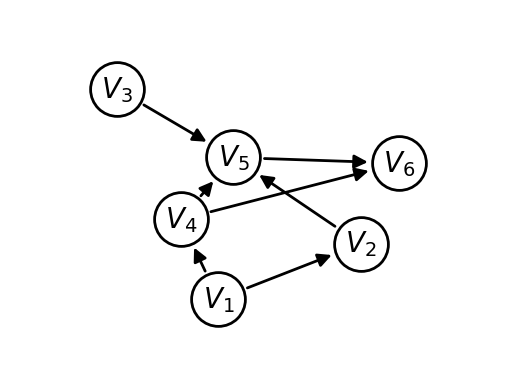

In [4]:
# def get_single_door_updated(
#     graph: NxMixedGraph, data: pd.DataFrame
# ) -> dict[tuple[Variable, Variable], float]:
#     """Estimate parameter values for a linear SCM using backdoor adjustment."""
#     rv = {}

#     for source, target in graph.directed.edges():
#         temp_graph = graph.copy()
#         temp_graph.directed.remove_edge(source, target)  # remove edge from source to target
#         pgmpy_graph = to_pgmpy_bayesian_network_updated(temp_graph)
#         try:
#             raw_adjustment_sets = pgmpy_graph.minimal_dseparator(source.name, target.name)
#             if raw_adjustment_sets is None:
#                 # There are no valid adjustment sets.
#                 continue
#             # Ensure we have a set of frozensets, with each frozenset containing variable names
#             adjustment_sets = {
#                 (
#                     frozenset([adjustment_set])
#                     if isinstance(adjustment_set, str)
#                     else frozenset(adjustment_set)
#                 )
#                 for adjustment_set in raw_adjustment_sets
#             }
#         except ValueError:
#             # There are no valid adjustment sets.
#             continue
#         if not adjustment_sets:
#             # There is a valid adjustment set, and it is the empty set, so just regress the target on the source.
#             adjustment_sets = frozenset([frozenset([])])
#         coefficients = []
#         for adjustment_set in adjustment_sets:
#             # Ensure adjustment_set is a set before performing the union operation.
#             variables = sorted(set(adjustment_set) | {source.name})
#             idx = variables.index(source.name)
#             model = LinearRegression()
#             model.fit(data[variables], data[target.name])
#             coefficients.append(model.coef_[idx])
#         rv[source, target] = fmean(coefficients)
#     return rv


# def to_pgmpy_bayesian_network_updated(graph: NxMixedGraph) -> BayesianNetwork:
#     """Convert a mixed graph to an equivalent :class:`pgmpy.BayesianNetwork`."""

#     # Get all directed edges with node names
#     edges = [(u.name, v.name) for u, v in graph.directed.edges()]

#     # Initialize set for latent variables
#     latents = set()

#     # Handle undirected edges by introducing latent variables
#     for u, v in graph.undirected.edges():
#         latent = f"U_{u.name}_{v.name}"
#         latents.add(latent)
#         edges.append((latent, u.name))
#         edges.append((latent, v.name))

#     # Initialize the BayesianNetwork with edges
#     model = BayesianNetwork(ebunch=edges, latents=latents)

#     # Add all original nodes to the BayesianNetwork
#     for node in graph.directed.nodes():
#         if node.name not in model.nodes():
#             model.add_node(node.name)

#     return model


np.random.seed(42)


# create model
graph = example_graph  # NxMixedGraph

graph.draw(prog="neato")

node_generators = {node: partial(uniform, low=2.0, high=4.0) for node in graph.nodes()}

edge_weights = {edge: uniform(low=1.0, high=2.0) for edge in graph.directed.edges()}
print(f"actual edge weights: {edge_weights}")


# simulate data
# df, fits = simulate(graph=graph, trials=100000, generators=node_generators, weights=edge_weights)

df = scm.simulate_lscm(
    graph=graph, node_generators=node_generators, edge_weights=edge_weights, n_samples=100000
)

display(df.head())

# calibrate model (edge weights) to data
# estimated_edge_weights = get_single_door_updated(graph, df)

estimated_edge_weights = scm.calibrate_lscm(graph, df)
print(f"estimated edge weights: {estimated_edge_weights}")

print(graph.directed.edges)

for edge, weight in edge_weights.items():
    estimated_weight = estimated_edge_weights[edge]
    # Use numpy.allclose to compare the weights with a tolerance
    assert np.allclose(
        weight, estimated_weight, atol=1e-2
    ), f"Edge {edge}: expected {weight}, got {estimated_weight}"

All tests passed!


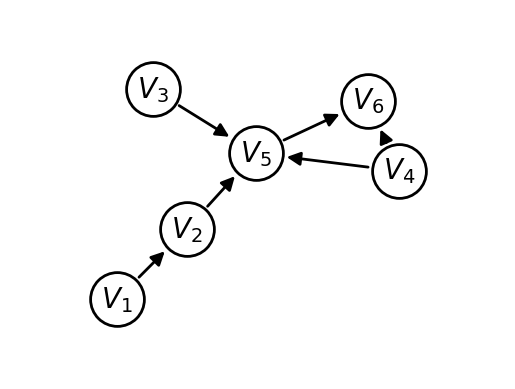

In [6]:
intervention_node = (Variable("V4"), 10.0)
intervened_lscm = scm.intervene_on_lscm(graph, intervention_node, node_generators, edge_weights)

# Check resulting graph and edge weights
intervened_graph = intervened_lscm.graph
intervened_generators = intervened_lscm.generators
intervened_weights = intervened_lscm.weights

# Draw the intervened graph
intervened_lscm.graph.draw(prog="neato")

# The edge ('V1', 'V4') should be removed along with its weight
assert ("V1", "V4") not in intervened_weights, "Edge ('V1', 'V4') should be removed from weights"
assert (
    "V1",
    "V4",
) not in intervened_graph.directed.edges(), "Edge ('V1', 'V4') should be removed from graph"

# Check that the node generator for 'V4' returns 10
assert (
    intervened_generators[Variable("V4")]() == 10.0
), "Generator for 'V4' should return the intervention value"

print("All tests passed!")

In [ ]:
def remove_incoming_edge_weights(edges_dict, target_node):
    """Return a new dictionary with weights of incoming edges to the target node set to 0."""
    # Create a new dictionary to avoid modifying the original
    new_edges_dict = edges_dict.copy()

    # Iterate over the edges and update the weight if it's an incoming edge to the target node
    for edge, weight in edges_dict.items():
        if edge[1] == target_node:
            new_edges_dict[edge] = 0

    return new_edges_dict


intervention_target = V4
intervened_edge_weights = remove_incoming_edge_weights(edge_weights, intervention_target)
print(f"intervened_edge_weights: {intervened_edge_weights}")

intervened_df, intervened_fits = simulate(
    graph=graph, trials=10000, generators=node_generators, weights=intervened_edge_weights
)
print(intervened_df.head())

In [8]:
def compute_average_treatment_effect(
    treatment1: pd.DataFrame, treatment2: pd.DataFrame, outcome_variables: list[Variable]
) -> dict[Variable, float]:
    "Computes the average treatment effect (i.e., E[Y1-Y0])."

    avg_treatment_effect_dict = {}
    for v in outcome_variables:
        avg_untreated = treatment1.loc[:, str(v)].mean()
        avg_treated = treatment2.loc[:, str(v)].mean()
        avg_treatment_effect = avg_treated - avg_untreated
        avg_treatment_effect_dict[v] = avg_treatment_effect
    return avg_treatment_effect_dict


avg_treatment_effect_dict = compute_average_treatment_effect(
    df, intervened_df, [V1, V2, V3, V4, V5, V6]
)
print(f"ATE - intervening on {intervention_target}: {avg_treatment_effect_dict}")

NameError: name 'intervened_df' is not defined

# E. Coli.

In [7]:
from nocap import utility

np.random.seed(42)
# load ecoli network

file_path = "/Users/geor228/Github/nocap/notebooks/ecoli/ECOLI-regulatory-network.txt"
ecoli_network = utility.parse_regulation_file(file_path)

print(len(ecoli_network.edges))

# nx.write_graphml(ecoli_network, "ecoli_full_network.graphml")

ImportError: cannot import name 'utility' from 'nocap' (/Users/geor228/Github/nocap/src/nocap/__init__.py)

## fadR

In [ ]:
# fadR
fadr_graph = utility.get_subgraph_from_nodes(ecoli_network, ["fadR"], descendants_only=False)
fadr_graph_dag = utility.convert_to_acyclic_graph_fancy(fadr_graph, "fadR")
fadr_graph_mixed = NxMixedGraph.from_str_edges(directed=fadr_graph_dag.edges)
print(len(fadr_graph_mixed.directed.nodes))
print(len(fadr_graph_mixed.directed.edges))

In [ ]:
# linear model
np.random.seed(42)
fadr_node_generators = {
    node: partial(uniform, low=-1.0, high=1.0) for node in fadr_graph_mixed.nodes()
}
fadr_edge_weights = {edge: uniform(low=0.0, high=1.0) for edge in fadr_graph_mixed.directed.edges()}
print(f"actual edge weights: {fadr_edge_weights}")

G = nx.DiGraph()

# Add edges and weights to the graph
for edge, weight in fadr_edge_weights.items():
    G.add_edge(edge[0], edge[1], weight=weight)

# Save the graph to a GraphML file (for visualization)
nx.write_graphml(G, "fadr_subnetwork_with_weights.graphml")

In [ ]:
# simulate data
fadr_df, fadr_fits = simulate(
    graph=fadr_graph_mixed, trials=1, generators=fadr_node_generators, weights=fadr_edge_weights
)
display(fadr_df.head())

In [ ]:
import cProfile
import io
import pstats


# Define your simulation function here
def profile_simulation():
    fadr_df, fadr_fits = simulate(
        graph=fadr_graph_mixed, trials=1, generators=fadr_node_generators, weights=fadr_edge_weights
    )


# Create a profiler object
profiler = cProfile.Profile()

try:
    # Start the profiler
    profiler.enable()

    # Run the simulation function
    profile_simulation()

    # Stop the profiler
    profiler.disable()

except KeyboardInterrupt:
    # Stop the profiler if interrupted (e.g., cell execution is canceled)
    profiler.disable()
    print("Profiling interrupted by user.")

finally:
    # Create a Stats object from the profiler's data
    stats = pstats.Stats(profiler, stream=io.StringIO()).sort_stats("cumulative")

    # Print the statistics to the console (or rather, to the notebook's output cell)
    stats.print_stats()

    # Retrieve the stats from the StringIO object and display them in the notebook
    print(stats.stream.getvalue())

    # Optionally, save the stats to a file for later analysis
    stats.dump_stats("profile_results.prof")

In [ ]:
#!pip install snakeviz

# # Load the SnakeViz extension in the Jupyter notebook
# %load_ext snakeviz

# # Visualize the saved profiling data with SnakeViz
# %snakeviz -t /Users/geor228/Github/nocap/notebooks/profile_results.prof

In [ ]:
# calibrate model (edge weights) to data
fadr_estimated_edge_weights = get_single_door_updated(fadr_graph_mixed, fadr_df)
print(f"estimated edge weights: {fadr_estimated_edge_weights}")

for edge, weight in fadr_edge_weights.items():
    estimated_weight = fadr_estimated_edge_weights[edge]
    # Use numpy.allclose to compare the weights with a tolerance
    assert np.allclose(
        weight, estimated_weight, atol=1e-2
    ), f"Edge {edge}: expected {weight}, got {estimated_weight}"


# # non-linear (Hill) model in SERGIO

In [ ]:
# simulate data for subnetworks

In [ ]:
# compute single door criterion

In [ ]:
# save

In [ ]:
def intervene_on_state_variable(
    model: NxMixedGraph, intervention: dict[y0.dsl.Variable, float]
) -> NxMixedGraph:
    pass


def intervene_on_parameter(
    model: NxMixedGraph, intervention: dict[sy.Symbol, float]
) -> NxMixedGraph:
    pass

In [ ]:
def sample_model(
    model: NxMixedGraph,
    n_samples: int,
    parameters: dict[sy.Symbol, float],
    parameter_interventions,
    state_interventions,
) -> pd.DataFrame:
    pass